# Function interpolation

This notebook shows how to interpolate functions represented as MPS using the SeeMPS library. There are two interpolation methods, Fourier interpolation and second order finite differences interpolation. More information about these methods can be found in https://arxiv.org/abs/2303.09430.

First, let us import the necessary set of tools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seemps.state import MPS #Create MPS
from seemps.analysis.space import Space #Create position space for problem definition
from seemps.analysis.interpolation import fourier_interpolation, finite_differences_interpolation #Interpolation

The Gaussian function
\begin{equation}
    f(x) = \frac{1}{\mathcal{N}}e^{-x^2/2},
\end{equation}
where $\mathcal{N}$ is normalization constant, acts as benchmark for the interpolation techniques.

In [2]:
def gaussian(x):
    """ Constructs a normalized Gaussian with mean zero and standard
        deviation one defined on x.
    
    Parameters
    ----------
    x: np.ndarray
        grid on which the Gaussian is defined

    Returns
    -------
    np.ndarray: Gaussian defined on x.
    """
    f = np.exp(-x**2/2)
    return f

Let us define a one-dimensional grid with $N=2^n$ points with coordinates $x_s = -L/2 + s\Delta x, \Delta x = L/N, s=\lbrace 0,...,N-1\rbrace$. The original function defined in this grid is $f(x_s)$. If we wanted to represent the function on a grid with more points, $M=2^m$ with $m>n$, we could obtain an approximation of the exact function on the new grid $f(x_r)$, $r=\lbrace 0,...,M-1\rbrace$, by interpolating $f(x_s)$ to obtain $f_\text{int}(x_r)$. The error of the interpolation is given by the norm-2 difference $\parallel f(x_r)-f_\text{int}(x_r)\parallel_ 2$, where $f(x_r)$ and $f_\text{int}(x_r)$ are normalized.

Let us define the functions to compute the error.

In [3]:
def remove_phase(v):
    """
    Removes the phase from a complex vector `v` by normalizing it with the phase 
    of its maximum magnitude element.
    
    Parameters
    ----------
    v : numpy.ndarray
        A complex vector or array-like object.

    Returns
    -------
    numpy.ndarray
        A complex vector of the same shape as `v` with its phase removed.
    
    Notes
    -----
    The phase of the vector is adjusted by multiplying it by the conjugate of 
    the element with the maximum magnitude, normalized by the absolute value of 
    that element. This operation effectively rotates the vector to align its 
    largest element with the positive real axis.
    """
    shape = v.shape
    v = v.flatten()
    k = np.argmax(np.abs(v))
    return (v * np.abs(v[k]) / v[k]).reshape(shape)

def norm2_difference(a, b):
    """
    Calculates the norm-2 difference between two vectors or MPS objects after 
    removing their phases and normalizing them.

    Parameters
    ----------
    a : numpy.ndarray or MPS
        The first vector or MPS object.
    b : numpy.ndarray or MPS
        The second vector or MPS object.

    Returns
    -------
    float
        The norm-2 (Euclidean) difference between the two vectors after phase 
        removal and normalization.

    Notes
    -----
    If `a` or `b` are instances of the `MPS` class, they are first converted to 
    vector form using the `to_vector()` method. The vectors are then phase-aligned 
    using the `remove_phase` function and normalized to unit length. The difference 
    is calculated using the Euclidean norm of the difference vector.
    """
    if isinstance(a, MPS):
        a = a.to_vector()
    if isinstance(b, MPS):
        b = b.to_vector()
    a = remove_phase(a)
    b = remove_phase(b)
    a /= np.linalg.norm(a)
    b /= np.linalg.norm(b)
    return np.linalg.norm(a - b)

The first step to perform interpolation is to construct the original function of an $n$-qubit grid and obtain its MPS representation. We use the `Space` class to create an object that encodes all the information necessary about the coordinates' space.

In [4]:
# Define n-qubit function
n = 3
N = 2**n
qubits_per_dimension = [n]
L = np.sqrt(2*np.pi*2**n)
space = Space(qubits_per_dimension, L=[[-L/2,L/2]], closed=False)
x_n = space.x[0]
f_n = gaussian(x_n)
f_n_mps = MPS.from_vector(f_n, [2]*n, normalize=False)

We are going to interpolate this function to a grid with $m=n+1$ qubits, i.e., we double the number of points of the grid. We need to define the new space on which the function is represented, as well as the function for its benchmark.

In [5]:
# Define m-qubit function on the interpolated grid
m = n+1
M = 2**m
new_space = space.increase_resolution([m])
x_m = new_space.x[0]
f_m = gaussian(x_m)

Now, let us apply Fourier and finite differences interpolation to approximate the $m$-qubit function.

In [6]:
# Create m-qubit interpolated function
f_fourier_mps = fourier_interpolation(f_n_mps, space, [n], [m])
f_fd_mps = finite_differences_interpolation(f_n_mps, space)
f_fourier = f_fourier_mps.to_vector()
f_fd = f_fd_mps.to_vector()

In [7]:
print(f'Norm-2 difference. Fourier = {norm2_difference(f_m, f_fourier)}, finite differences = {norm2_difference(f_m, f_fd)}')

Norm-2 difference. Fourier = 0.0017046110416319286, finite differences = 0.05373191742570684


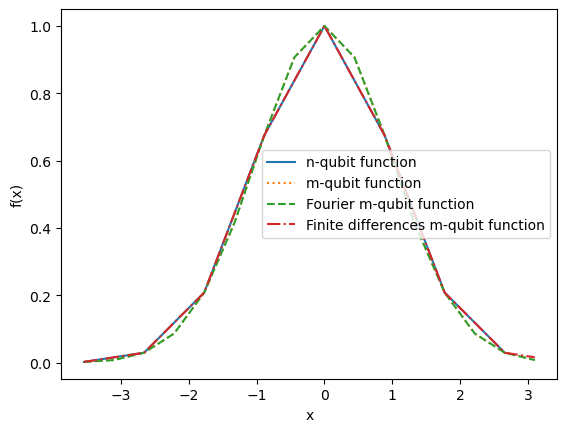

In [8]:
fig, ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.plot(x_n, f_n, linestyle='solid', label='n-qubit function')
ax.plot(x_m, f_m, linestyle='dotted', label='m-qubit function')
ax.plot(x_m, f_fourier.real, linestyle='dashed', label='Fourier m-qubit function')
ax.plot(x_m, f_fd, linestyle='dashdot', label='Finite differences m-qubit function')

ax.legend()

For this small number of points we can just by inspection conclude that the Fourier interpolation leads to a better approximation of the $m$-qubit function. This is also checked numerically via the norm-2 difference. We can also play with the `Strategy` to increase the MPS precision.

Let us study the scaling of the errors with the number of qubits. We can reconstruct the final $m$-qubit function from different original grids with $m-1,m-2,\dots,n$ points, with $n<m$, and compute the error of each approximation. This enables determining how many points of the original function lead to a good approximation of the $m$-qubit function. The Fourier interpolation allows us to add as many qubits as we want. However, when using finite differences, to chain successive finite differences interpolations is necessary, as each decreases the number of points by two.

In [9]:
n = 3
qubits_per_dimension = [n]
L = np.sqrt(2*np.pi*2**n)
space = Space(qubits_per_dimension, L=[[-L/2,L/2]], closed=False)
m = 12
M = 2**m
new_space = space.increase_resolution([m])
x_m = new_space.x[0]
f_m = gaussian(x_m)
f_m /= np.linalg.norm(f_m)

In [10]:
f_fds = []
f_fouriers = []
n_qubits = range(3,m)
for n in n_qubits:
    N = 2**n
    space = space.increase_resolution([n])
    x_n = space.x[0]
    f_n = gaussian(x_n)
    f_n_mps = MPS.from_vector(f_n, [2]*n, normalize=False)
    f_fourier_mps = fourier_interpolation(f_n_mps, space, [n], [m])
    f_fd_mps = f_n_mps.copy()
    for n_i in range(n,m):
        f_fd_mps = finite_differences_interpolation(f_fd_mps, space.increase_resolution([n_i]))
    f_fourier = f_fourier_mps.to_vector()
    f_fd = f_fd_mps.to_vector()
    f_fds.append(f_fd/np.linalg.norm(f_fd))
    f_fouriers.append(f_fourier/np.linalg.norm(f_fourier))

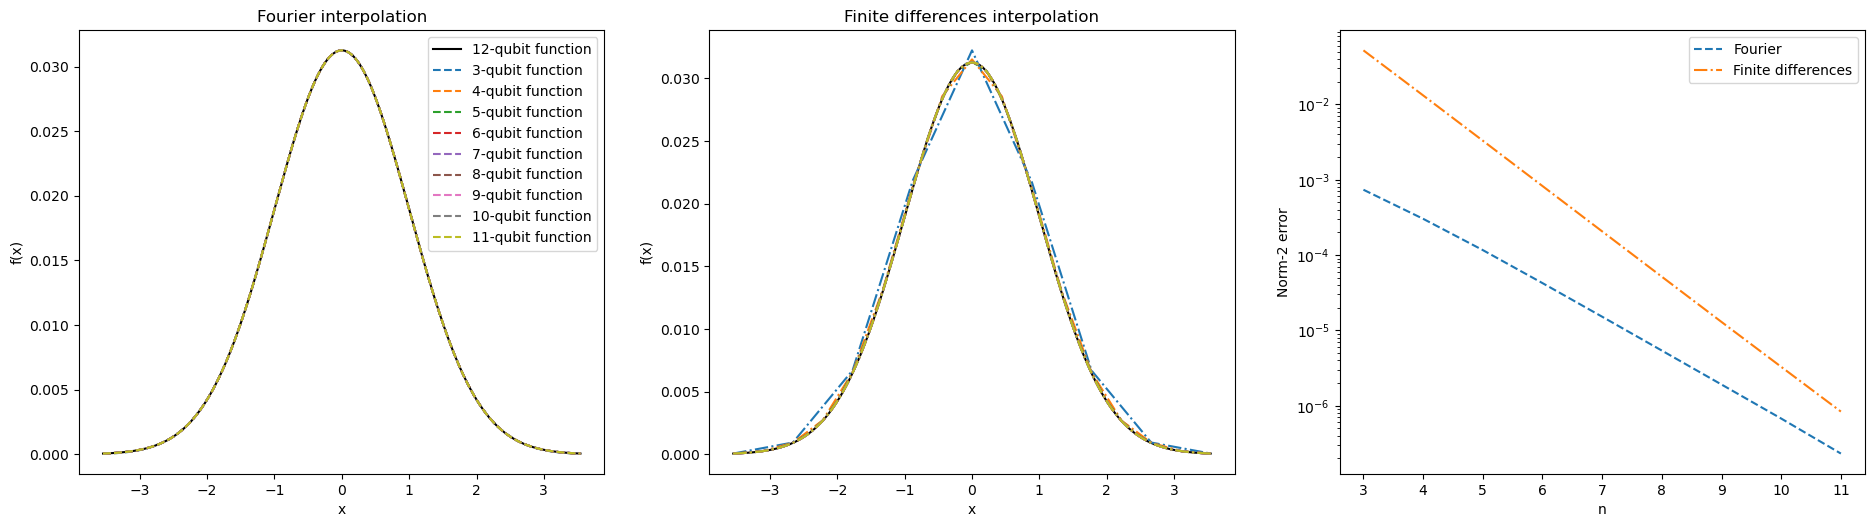

In [11]:
fig, ax = plt.subplots(1,3,figsize=(6.4*1.2*3,4.8*1.2))
ax[0].set_title('Fourier interpolation')
ax[0].set_xlabel('x')
ax[0].set_ylabel('f(x)')
ax[1].set_title('Finite differences interpolation')
ax[1].set_xlabel('x')
ax[1].set_ylabel('f(x)')
ax[2].set_xlabel('n')
ax[2].set_ylabel('Norm-2 error')
ax[0].plot(x_m, f_m, color='k', linestyle='solid', label=f'{m}-qubit function')
ax[1].plot(x_m, f_m, color='k', linestyle='solid', label=f'{m}-qubit function')
for i, n in enumerate(n_qubits):
    ax[0].plot(x_m, f_fouriers[i].real, linestyle='dashed', label=f'{n}-qubit function')
    ax[1].plot(x_m, f_fds[i].real, linestyle='dashdot', label=f'{n}-qubit function')
ax[2].plot(n_qubits, [norm2_difference(f_m,f_fouriers[i].real) for i, n in enumerate(n_qubits)], linestyle='dashed', label=f'Fourier')
ax[2].plot(n_qubits, [norm2_difference(f_m,f_fds[i].real) for i, n in enumerate(n_qubits)], linestyle='dashdot', label=f'Finite differences')
ax[2].set_yscale('log')
ax[0].legend()
ax[2].legend()

Fourier interpolation leads to a better approximation than finite differences.

Fourier interpolation and finite differences interpolation can also be extended to multidimensional functions, defining a multidimensional `Space` object.